In [1]:
import pandas as pd
import os
import re
from datetime import datetime, timedelta
import cv2
import numpy as np
import matplotlib.pyplot as plt
from image_points import *
from read_positions import read_positions
import largestinteriorrectangle as lir
%matplotlib inline
from helper import *



In [2]:
df = read_positions(label_dir='../../data/labels', output_csv='positions.csv')
df = df[df['Camera']==1]
df.head(11)

,Camera,Date,X_center,Y_center,Width,Height
22,1,2024-01-24 12:15:00,0.840104,0.5300,0.308333,0.524
23,1,2024-01-24 12:15:00,0.779948,0.2885,0.209896,0.365
36,1,2024-01-27 02:15:00,0.597135,0.7150,0.249479,0.562
37,1,2024-01-27 02:15:00,0.485677,0.5800,0.315104,0.334
112,1,2024-01-27 02:00:00,0.601302,0.7155,0.243229,0.553
113,1,2024-01-27 02:00:00,0.444792,0.5680,0.236458,0.340
121,1,2024-01-27 03:45:00,0.663281,0.7185,0.185938,0.325
122,1,2024-01-27 03:45:00,0.487760,0.6525,0.202604,0.307
123,1,2024-01-27 03:45:00,0.508594,0.8895,0.265104,0.211
134,1,2024-01-26 17:00:00,0.257292,0.1745,0.194792,0.255


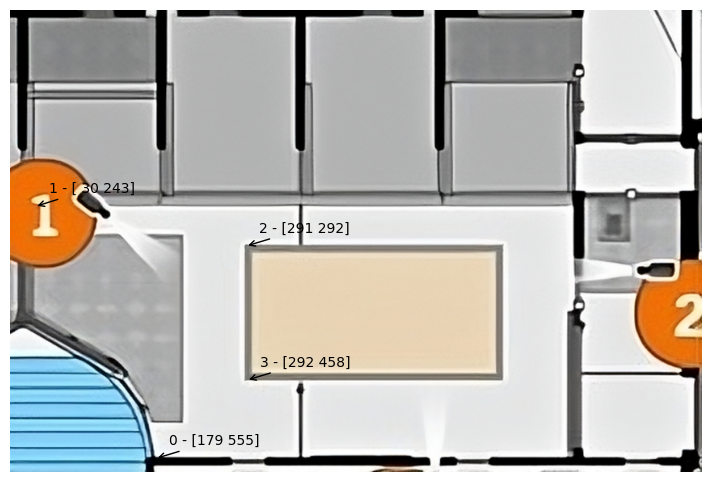

In [3]:
background = cv2.imread('back.jpeg')
plot_images(background)
for i, pt in enumerate(MAP_PTS_1):
    plt.annotate(str(i) + " - " + str(pt), xy=pt, textcoords="offset points", xytext=(10,10), arrowprops=dict(arrowstyle="->"))

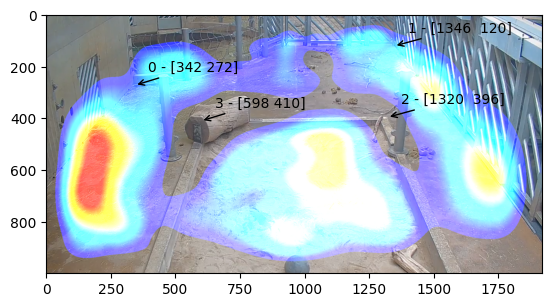

In [4]:
img = cv2.imread('heat.png')
show(img)
for i, pt in enumerate(IMAGE_PTS_1):
    plt.annotate(str(i) + " - " + str(pt), xy=pt, textcoords="offset points", xytext=(10,10), arrowprops=dict(arrowstyle="->"))

In [4]:
def transform_row2(M, x, y, width, height):

    def transform_point(M, x, y):
        points = np.array([[x, y]], dtype='float32')  
        points_reshaped = np.array([points])
        pointsOut = cv2.perspectiveTransform(points_reshaped, H)
        return pointsOut[0,0,0], pointsOut[0,0,1]

    x_proj, y_proj = transform_point(M, x, y)
    
    left, right = x - width/2, x + width/2
    up, down = y - height/2, y + height/2

    upper_left_proj = transform_point(M, left, up)
    upper_right_proj = transform_point(M, right, up)
    lower_left_proj = transform_point(M, left, down)
    lower_right_proj = transform_point(M, right, down)        
    return x_proj, y_proj, [upper_left_proj, upper_right_proj, lower_right_proj, lower_left_proj]

def shift(x, y, width, height):
    y += height/2
    return x, y, width, height
    
    
    

In [5]:
H, mask = cv2.findHomography(IMAGE_PTS_1, MAP_PTS_1)

df_proj = pd.DataFrame(columns=['Camera', 'Date', 'X_center', 'Y_center', 'Point1', 'Point2', 'Point3', 'Point4'])
for index, row in df.iterrows():
    data = {}
    data['Camera'] = row['Camera']
    data['Date'] = row['Date']
    x, y, width, height = row['X_center'], row['Y_center'], row['Width'], row['Height']
    x, y = x*IMG_WIDTH, y*IMG_HEIGHT
    width, height = width*IMG_WIDTH, height*IMG_HEIGHT
    # print(f'x, y, w, h = {x, y, width, height}')
    x, y, width, height = shift(x, y, width, height)
    x_proj, y_proj, polygon= transform_row2(H, x, y, width, height)

    map_width, map_height = MAP_WIDTH12, MAP_HEIGHT12
    polygon = [(x/map_width, y/map_height) for x, y in polygon]
    # print(polygon)  
    data['X_center'], data['Y_center'] = x_proj/map_width, y_proj/map_height
    for idx, col in enumerate(['Point1', 'Point2', 'Point3', 'Point4']):
        data[col] = polygon[idx]
    
    df_proj = pd.concat([df_proj, pd.DataFrame([data])], ignore_index=True)
df_proj.head()

/tmp/ipykernel_917261/3940408199.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_proj = pd.concat([df_proj, pd.DataFrame([data])], ignore_index=True)


,Camera,Date,X_center,Y_center,Point1,Point2,Point3,Point4
0,1,2024-01-24 12:15:00,0.530163,0.479323,"(0.4225993290125767, 0.5305024793931654)","(0.42594332115672456, 0.34081415029672474)","(0.5973149593745437, 0.44737251655205146)","(0.5989260094188084, 0.5707098687445367)"
1,1,2024-01-24 12:15:00,0.390834,0.459810,"(0.24963676595242223, 0.5005401931442581)","(0.2580349645882009, 0.32585434813599484)","(0.48088982840564765, 0.43383210188858995)","(0.480010986328125, 0.5497634460876039)"
2,1,2024-01-27 02:15:00,0.586367,0.605796,"(0.5034974356678045, 0.664886474609375)","(0.5039595131562135, 0.529992750474623)","(0.6401481271904206, 0.5674473155628551)","(0.6419575058411215, 0.656931043504835)"
3,1,2024-01-27 02:15:00,0.515128,0.657088,"(0.4446423967307973, 0.7608648446890024)","(0.44727521522022856, 0.5621282937643411)","(0.5657956488778658, 0.5824892270815122)","(0.5668693970296984, 0.7295007238854895)"
4,1,2024-01-27 02:00:00,0.585408,0.603890,"(0.5036979390081958, 0.6608447094897291)","(0.5041436881662529, 0.5294927850469843)","(0.6387654955142013, 0.5666992614319274)","(0.6405169050270152, 0.6543420644906851)"


In [12]:
df_proj.head(11)

,Camera,Date,X_center,Y_center,Point1,Point2,Point3,Point4
0,1,2024-01-24 12:15:00,0.424299,0.434061,"(0.2296415311153804, 0.4865028007880791)","(0.2430561279582086, 0.22709546389279667)","(0.5300776757926584, 0.4055645815976016)","(0.530251084087051, 0.555050082973667)"
1,1,2024-01-24 12:15:00,0.253901,0.411838,"(0.007848368626888667, 0.44887820157137787)","(0.029211572397535093, 0.21498472040349786)","(0.3924490670177424, 0.3909807271890707)","(0.38917876626843606, 0.5303556535627458)"
2,1,2024-01-27 02:15:00,0.503731,0.596655,"(0.36180175353433486, 0.6730277855079491)","(0.3667830351357148, 0.4922665682705966)","(0.5857905450268327, 0.5524979171219405)","(0.5869546337662456, 0.6600913201178704)"
3,1,2024-01-27 02:15:00,0.445981,0.659811,"(0.34374286972473717, 0.7867562354027808)","(0.35099029541015625, 0.545587232896498)","(0.5152480223468531, 0.5738055355898983)","(0.5150040599787347, 0.7428096424449574)"
4,1,2024-01-27 02:00:00,0.503923,0.594424,"(0.36532781725731966, 0.6674210875184385)","(0.3700494142336266, 0.4924320674442745)","(0.584853270343531, 0.5517991072648055)","(0.5859737931010879, 0.6569343513542122)"
5,1,2024-01-27 02:00:00,0.439693,0.686270,"(0.332453504901066, 0.7909140420126748)","(0.3384058943418699, 0.6044101314944821)","(0.5120140146986346, 0.6156992345423131)","(0.5117577526056878, 0.7445118510639751)"
6,1,2024-01-27 03:45:00,0.505133,0.561367,"(0.43482964061130985, 0.606042555162123)","(0.4365990184177862, 0.49033643815900896)","(0.5565601598436587, 0.528687217018821)","(0.5570583521762741, 0.6151845972021143)"
7,1,2024-01-27 03:45:00,0.478776,0.657300,"(0.4014761737573927, 0.7307079822033435)","(0.4043516355140187, 0.5911001992392373)","(0.5347723203284718, 0.604123575704081)","(0.5349713619624343, 0.7072852608207223)"
8,1,2024-01-27 03:45:00,0.559596,0.644456,"(0.5277867896534573, 0.7140543477518575)","(0.5276892474878614, 0.5769944624467329)","(0.585928765412803, 0.5868392090697389)","(0.5871784531067465, 0.7027767688244373)"
9,1,2024-01-26 17:00:00,0.083597,0.935865,"(-0.20039875707893728, 1.1915890353542942)","(-0.16480084000346817, 0.8774353240753388)","(0.24950152245637414, 0.7864765620731807)","(0.24096387346214224, 0.9728821441010161)"


572 856


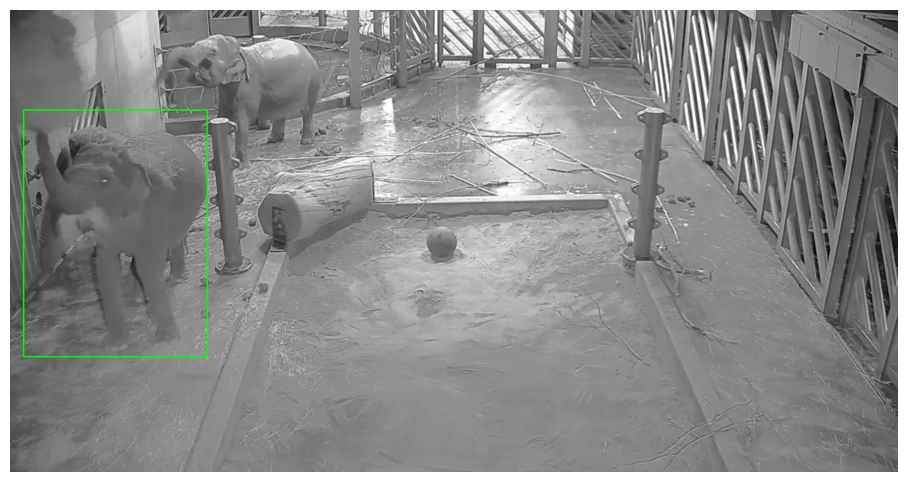

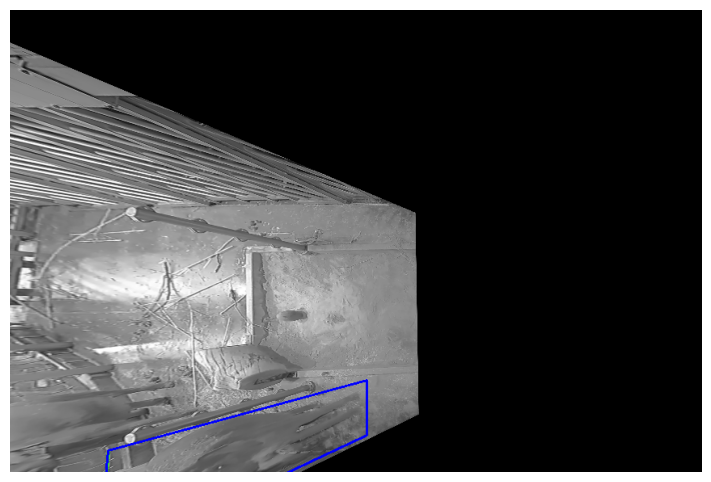

In [23]:
image = cv2.imread('../../data/images/screenshot1_26_01__16_00.png')
x,y,z, h = 0.119010,	0.4830,	0.206771,	0.534
plot_rectangle_on_image(image, x*1920, y*1000, z*1920, h*1000)
plot_images(image)
#Plot a rectangle on the image
# plot_rectangle_on_image(image, cx=100, cy=150, w=50, h=100, color=(255, 0, 0), thickness=2)

# Show the image with the rectangle
# cv2.imshow('Image with Rectangle', image)
height, width = background.shape[:2]
print(height, width)
dst = cv2.warpPerspective(image, H, (width, height))

a,b,c,d = 0.321421,	0.900659, 0.389158,	0.198682,

# plot_rectangle_on_image(dst,a*MAP_WIDTH12, b*MAP_HEIGHT12, c*MAP_WIDTH12,	d*MAP_HEIGHT12)
polygon = [(-0.20039875707893728, 1.1915890353542942),	(-0.16480084000346817, 0.8774353240753388),	(0.24950152245637414, 0.7864765620731807),	(0.24096387346214224, 0.9728821441010161)]
polygon = [(x*MAP_WIDTH12, y*MAP_HEIGHT12) for x, y in polygon]

polygion = [(0.1268419550958081, 1.1945075188483392),	(0.14181927654230705, 0.9531989464393029),	(0.5159996246623102, 0.8013181886472902),	(0.5158500314872956, 0.9197066513808457)]
polygion = [(x*MAP_WIDTH12, y*MAP_HEIGHT12) for x, y in polygion]
plot_polygon_on_image(dst, [polygion], True, (255,0,0))
plot_images(dst)

In [10]:
def get_heatmap_new(df, camera):
    df = df[df['Camera'] == camera]

    # Specify the dimensions of the heatmap
    heatmap_width, heatmap_height = 856, 572

    # Initialize a blank image for the heatmap
    heatmap_img = np.zeros((heatmap_height, heatmap_width), dtype=np.float32)

    # Function to apply intensity within the bounding box area
    def apply_bounded_gaussian_heatmap_polygon(cx, cy, points, heatmap):
        vertices = np.array(points, dtype=np.int32)
    
        # Calculate the bounding box of the polygon to limit the area for the point-in-polygon test
        p_x, p_y, width, height = cv2.boundingRect(vertices)
        left = max(0, p_x)
        right = min(heatmap_width-1, p_x + width)
        top = max(0, p_y)
        bottom = min(heatmap_height-1, p_y + height)
    
        # Calculate sigma values based on the bounding box
        # width = bounding_box[2]
        # height = bounding_box[3]
        sigma_x = width / 4
        sigma_y = height / 4
        # Iterate over each point in the bounding box
        for y in range(top, bottom):
            for x in range(left, right):
                # Check if the point is inside the polygon
                if cv2.pointPolygonTest(vertices, (x, y), False) >= 0:
                    # Apply Gaussian intensity if the point is inside
                    dx = cx - x
                    dy = cy - y
                    value = np.exp(-(dx ** 2 / (2 * sigma_x ** 2) + dy ** 2 / (2 * sigma_y ** 2)))
                    heatmap[y, x] += value
                    
    for index, row in df.iterrows():
        cx, cy = row['X_center'] * heatmap_width, row['Y_center'] * heatmap_height
        cols = ['Point1', 'Point2', 'Point3', 'Point4']
        polygon = [(float(row[col][0])*heatmap_width, float(row[col][1]) *heatmap_height) for col in cols]
    
        apply_bounded_gaussian_heatmap_polygon(cx, cy, polygon, heatmap_img)


    cv2.normalize(heatmap_img, heatmap_img, 0, 255, norm_type=cv2.NORM_MINMAX)
    zero_mask = (heatmap_img < 20)
    #heatmap_img[zero_mask] = 0
    # Apply a colormap to create a color heatmap
    heatmap_color = cv2.applyColorMap(np.uint8(heatmap_img), cv2.COLORMAP_JET)
    heatmap_color[zero_mask] = (0,0,0)
    # plt.figure()
    # plt.imshow(heatmap_color[..., ::-1])  # change channels order since the YOLO work on BGR images
    # plt.show()
    return heatmap_color


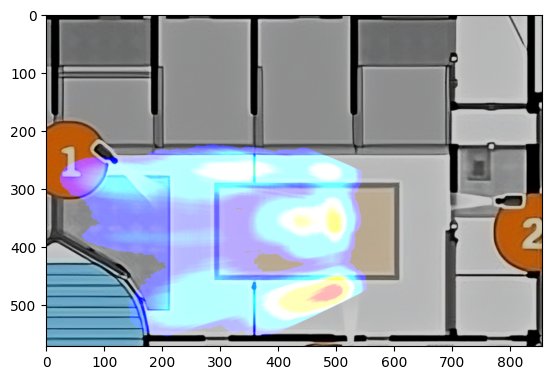

In [11]:
# Optionally, load an actual image to overlay the heatmap on
original_img = cv2.imread('back.jpeg')
heatmap_color = get_heatmap_new(df_proj, 1)
overlayed_img = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)
plt.figure()
plt.imshow(overlayed_img[..., ::-1])  # change channels order since the YOLO work on BGR images
plt.show()
